<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/flower_TensoreFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel("/content/drive/MyDrive/Tanjila_mam/DS-Healthcare_version_2.xlsx")

# Flower Quickstart (Simulation with TensorFlow/Keras)

Welcome to Flower, a friendly federated learning framework!

In this notebook, we'll simulate a federated learning system with 100 clients. The clients will use TensorFlow/Keras to define model training and evaluation. Let's start by installing Flower (published as `flwr` on PyPI) with the `simulation` extra:

In [3]:
!pip install -q flwr["simulation"] tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 41.0 MB/s eta 0:00:00


Let's also install Matplotlib so we can make some plots once the simulation is completed

In [4]:
!pip install matplotlib

Next, we import the required dependencies. The most important imports are Flower (`flwr`) and TensorFlow:

In [58]:
import math
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

VERBOSE = 0
NUM_CLIENTS = 100

Let's start by defining the model we want to federated. Since we will be working with MNIST, using a fully connected model is sufficient. You can of course customize this model.

In [68]:
def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[9]),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation="softmax"),
        ]
    )
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

With that out of the way, let's move on to the interesting bits. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

- `get_parameters`: Return the current local model parameters
- `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
- `evaluate`: Received model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use TensorFlow/Keras for the model training and evaluation. Keras models provide methods that make the implementation straightforward: we can update the local model with server-provides parameters through `model.set_weights`, we can train/evaluate the model through `fit/evaluate`, and we can get the updated model parameters through `model.get_weights`.

Let's see a simple implementation:

In [69]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, x_train, y_train, x_val, y_val) -> None:
        # Create model
        self.model = get_model()
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.x_train, self.y_train, epochs=1, batch_size=32, verbose=VERBOSE
        )
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(
            self.x_val, self.y_val, batch_size=64, verbose=VERBOSE
        )
        return loss, len(self.x_val), {"accuracy": acc}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate, is there?), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 100 clients on a single machine. This means that the server and all 100 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 100 clients would mean having 100 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for each client

We now define four auxiliary functions for this example (note the last two are entirely optional):
* `get_client_fn()`: Is a function that returns another function. The returned `client_fn` will be executed by Flower's VirtualClientEngine each time a new _virtual_ client (i.e. a client that is simulated in a Python process) needs to be spawn. When are virtual clients spawned? Each time the strategy samples them to do either `fit()` (i.e. train the global model on the local data of a particular client) or `evaluate()` (i.e. evaluate the global model on the validation set of a given client).

* `partition_mnist()`: A utility function that downloads the MNIST dataset and partitions it into `NUM_CLIENT` disjoint sets. The resulting list of dataset partitions will be passed to `get_client_fn()` so a client can be constructed by passing it its corresponding dataset partition. There are multiple ways of partitioning a dataset, but in this example we keep things simple. For larger dataset, you might want to pre-partition your dataset before running your Flower experiment and, potentially, store these partition into your files system or a database. In this way, your `FlowerClient` objects can retrieve their data directly when doing either `fit()` or `evaluate()`.

* `weighted_average()`: This is an optional function to pass to the strategy. It will be executed after an evaluation round (i.e. when client run `evaluate()`) and will aggregate the metrics clients return. In this example, we use this function to compute the weighted average accuracy of clients doing `evaluate()`.

* `get_evaluate_fn()`: This is again a function that returns another function. The returned function will be executed by the strategy at the end of a `fit()` round and after a new global model has been obtained after aggregation. This is an optional argument for Flower strategies. In this example, we use the whole MNIST test set to perform this server-side evaluation.

In [8]:
#(x_train, y_train), testset = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [39]:
#testset[1].shape,testset[0].shape

((10000,), (10000, 28, 28))

In [24]:
#y_train.shape

(60000,)

In [19]:
""""

a = df.iloc[:,4:]
b = df['Type']
from sklearn.model_selection import train_test_split
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size = 0.33, random_state = 0)""""

In [21]:
#a_train = a_train.to_numpy()

In [27]:
#b_train = b_train.to_numpy()

In [28]:
#b_train.shape

(595507,)

In [29]:
#a_train.shape

(595507, 9)

In [36]:
#k = (a_train,b_train)

In [38]:
#k[0].shape,k[1].shape

((595507, 9), (595507,))

In [64]:
"""encoder=LabelEncoder()
df['Type']=encoder.fit_transform(df['Type'])
X = df.iloc[:,4:]
y = df['Type']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
testset = (x_test,y_test)"""

In [65]:
"""model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[9]),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation="softmax"),
        ]
    )
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])"""

In [ ]:
#histomodel.fit(x_train,y_train,epochs=1, batch_size=32, verbose=VERBOSE)

In [ ]:
#model.get_weights()

In [70]:
def get_client_fn(dataset_partitions):
    """Return a function to be executed by the VirtualClientEngine in order to construct
    a client."""

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        x_train, y_train = dataset_partitions[int(cid)]
        # Use 10% of the client's training data for validation
        split_idx = math.floor(len(x_train) * 0.9)
        x_train_cid, y_train_cid = (
            x_train[:split_idx],
            y_train[:split_idx],
        )
        x_val_cid, y_val_cid = x_train[split_idx:], y_train[split_idx:]

        # Create and return client
        return FlowerClient(x_train_cid, y_train_cid, x_val_cid, y_val_cid)

    return client_fn


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def partition_mnist():
    """Download and partitions the MNIST dataset."""
    #x_train, y_train), testset = tf.keras.datasets.mnist.load_data()

    encoder=LabelEncoder()
    df['Type']=encoder.fit_transform(df['Type'])
    X = df.iloc[:,4:]
    y = df['Type']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    testset = (x_test,y_test)
    print(type(x_train))
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(x_train) / NUM_CLIENTS)
    for cid in range(NUM_CLIENTS):
        # Split dataset into non-overlapping NUM_CLIENT partitions
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        partitions.append((x_train[idx_from:idx_to] / 255.0, y_train[idx_from:idx_to]))
    return partitions, testset


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate

We now have `FlowerClient` which defines client-side training and evaluation, and `client_fn`, which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate `num_clients`, the number of rounds `num_rounds`, and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower comes with a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - actually starts the simulation.

In [71]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create dataset partitions (needed if your dataset is not pre-partitioned)
partitions, testset = partition_mnist()

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

INFO flwr 2023-10-02 05:04:07,204 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


<class 'numpy.ndarray'>


2023-10-02 05:04:11,852	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-02 05:04:15,979 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7781690574.0, 'object_store_memory': 3890845286.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7781690574.0, 'object_store_memory': 3890845286.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-10-02 05:04:15,987 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-10-02 05:04:16,053 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO flwr 2023-10-02 05:04:16,075 | server.py:89 | Initializing global parameters
INFO:flwr:Initializing globa

You can then use the resturned History object to either save the results to disk or do some visualisation (or both of course, or neither if you like chaos). Below you can see how you can plot the centralised accuracy obtainined at the end of each round (including at the very beginning of the experiment) for the global model. This is want the function evaluate_fn() that we passed to the strategy reports.

history.metrics_centralized = {'accuracy': [(0, 0.3000409007072449), (1, 0.6553271412849426), (2, 0.6634175181388855), (3, 0.6723739504814148), (4, 0.6963110566139221), (5, 0.7400941252708435), (6, 0.7582659721374512), (7, 0.7687054872512817), (8, 0.7729842066764832), (9, 0.7733899354934692), (10, 0.7706590294837952)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

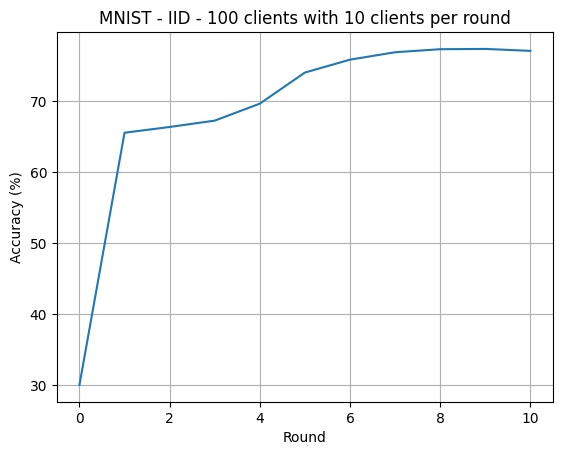

In [72]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

Congratulations! With that, you built a Flower client, customized it's instantiation through the `client_fn`, customized the server-side execution through a `FedAvg` strategy configured for this workload, and started a simulation with 100 clients (each holding their own individual partition of the MNIST dataset).

Next, you can continue to explore more advanced Flower topics:

- Deploy server and clients on different machines using `start_server` and `start_client`
- Customize the server-side execution through custom strategies
- Customize the client-side execution through `config` dictionaries